In [2]:
import os
os.chdir("./src")
print(os.getcwd())

/home/qudgks/workspace/NCLAD-tset/CLAD-master/src


In [2]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import config
import pdb
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.model_selection import train_test_split
col = ["red","green","blue","yellow","pink","orange","purple","brown","cyan","magenta",
   "lightblue","aqua",'tan','indigo','lime','tomato','maroon','gold','chartreuse','khaki']

cuda


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from transformers import DataCollatorForLanguageModeling,BertTokenizer
from models.utils import plot_distribution
import numpy as np
import time
import os

import config

from data_util.embeddings import bert_test_data, testDataset, NewsDataset

import pdb

bert_classifier = ["bert","DEC_bert","bert_scr"]
def apply_odin(net, train_x, test_in, test_out,center,test_in_emb = None,test_out_emb= None):

    print("in-distribution data")
    train_x_loader = DataLoader(train_x, batch_size=1, shuffle=False)
    test_in_loader = DataLoader(test_in, batch_size=1, shuffle=False)
    test_out_loader = DataLoader(test_out, batch_size=1, shuffle=False)   
    
    
    test_num = max(len(test_in), len(test_out))
    score_ = []
    criterion = nn.CrossEntropyLoss()
    t0 = time.time()
    if os.path.exists(config.sf_scores_path) == False:
        os.makedirs(config.sf_scores_path)
    f1 = open(config.base_in_path, "w")
    f2 = open(config.base_out_path, "w")
    g1 = open(config.odin_in_path, "w")
    g2 = open(config.odin_out_path, "w")

    temper = config.temperature
    noise_magnitude = config.perturbation
    cls_emb = []
    lab = []
    train_x_emb = []
    test_in_emb = []
    test_out_emb = []
    cls_pred = []
    cls_train = []
    for j, data in enumerate(train_x_loader):
        #base
        if config.classifier_type in bert_classifier :
            net.eval()
            #outputs, inputs = net(data['input_ids'].to(config.device),data['attention_mask'].to(config.device),1, None)
            outputs, inputs, hiden_state = net(data['input_ids'].to(config.device),data['attention_mask'].to(config.device),1, 0)
            nnOutputs = outputs.data.cpu()
            nnOutputs = nnOutputs.numpy()
            nnOutputs = nnOutputs.reshape(1, -1) #*distence.reshape(1, -1) #가까운 클러스터에 더 많은 가중치 부여
            nnOutputs = nnOutputs - np.max(nnOutputs)
            nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            cls_train.append(np.argmax(nnOutputs))
            train_x_emb.append(hiden_state.detach().cpu())
            
    for j, data in enumerate(test_in_loader):
        #base
        if config.classifier_type in bert_classifier :
            net.eval()
            #outputs, inputs = net(data['input_ids'].to(config.device),data['attention_mask'].to(config.device),1, None)
            outputs, inputs, hiden_state = net(data['input_ids'].to(config.device),data['attention_mask'].to(config.device),1, 0)
            test_in_emb.append(hiden_state.detach().cpu())
       
        else:
            inputs = Variable(data.float().cuda(config.device),requires_grad=True)     
            net.eval()
            outputs = net(inputs)
        #outputs = outputs.reshape(1,-1)
        
        # Calculating the confidence of the output, no perturbation added here, no temperature scaling used
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        
        if config.classifier_type in ['dec']:
            pass

        else :
            nnOutputs = nnOutputs.reshape(1, -1) #*distence.reshape(1, -1) #가까운 클러스터에 더 많은 가중치 부여
            nnOutputs = nnOutputs - np.max(nnOutputs)
            nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            #s = np.multiply(nnOutputs.reshape(-1),distence.reshape(-1))
            
        f1.write("{}, {}, {}\n".format(temper, noise_magnitude,
                                       np.max(nnOutputs)))
        cls_pred.append(np.argmax(nnOutputs))
        score_.append(np.max(nnOutputs))
        
          # Using temperature scaling
        outputs = outputs / temper
    
          # Calculating the perturbation we need to add, that is,
          # the sign of gradient of cross entropy loss w.r.t input
        maxIndexTemp = np.argmax(nnOutputs)
        lab.append(maxIndexTemp)
        labels = Variable(torch.LongTensor([maxIndexTemp]).cuda(config.device))
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = torch.ge(inputs.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2
        gradient = gradient * 50 / (79.0 / 255.0)
        
        #odin
        if config.classifier_type in bert_classifier:
            outputs, inputs_, _ = net(data['input_ids'].to(config.device),data['attention_mask'].to(config.device),1, 0)
            outputs = outputs / temper
        
#        elif config.classifier_type == 'DEC_bert':
#            outputs, inputs = net(data)
        
        else:
            tempInputs = torch.add(inputs.data, -noise_magnitude, gradient)
            outputs = net(Variable(tempInputs))
            outputs = outputs / temper

        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        
        if config.classifier_type in ['dec']: 
            outputs = outputs * temper
            
        else :
            nnOutputs = nnOutputs.reshape(-1)#*distence.reshape(-1)
            nnOutputs = nnOutputs - np.max(nnOutputs)
            nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            #s = np.multiply(nnOutputs.reshape(-1),distence.reshape(-1))
            
            
        g1.write("{}, {}, {}\n".format(temper, noise_magnitude,
                                       np.max(nnOutputs)))

        if j % 100 == 99:
            print("{:4}/{:4} data processed, {:.1f} seconds used.".format(
                j + 1,
                #  test_num,
                len(test_in_loader),
                time.time() - t0))
            t0 = time.time()

        if j > test_num:
            break

        torch.cuda.empty_cache()

    # out distribution test
    print("out-of-distribution data")

    normal_cls = len(cls_emb)

    for j, data in enumerate(test_out_loader):
        
        #base
        if config.classifier_type in bert_classifier:
            net.eval()
            outputs, inputs, hiden_state = net(data['input_ids'].to(config.device),data['attention_mask'].to(config.device),1, 0)
            test_out_emb.append(hiden_state.detach().cpu())
            #outputs, inputs = net(data['input_ids'].to(config.device))
        
        else:
            inputs = Variable(data.cuda(config.device), requires_grad=True) #오딘은 무조건 숫자여야함        
            net.eval()
            outputs = net(inputs)       

        #outputs = outputs.reshape(1,-1)
        # Calculating the confidence of the output, no pertyrbation added here
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        if config.classifier_type in ['dec']:
            pass
        
        else :
            nnOutputs = nnOutputs.reshape(1,-1)#*distence.reshape(1,-1)
            nnOutputs = nnOutputs - np.max(nnOutputs)
            nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            #s = np.multiply(nnOutputs.reshape(-1),distence.reshape(-1))
            
        

        f2.write("{}, {}, {}\n".format(temper, noise_magnitude,
                                       np.max(nnOutputs)))
        cls_pred.append(np.argmax(nnOutputs))
        score_.append(np.max(nnOutputs))
              
          # Using temperature scaling
        outputs = outputs / temper

        # Calculating the perturbation we need to add, that is,
        # the sign of gradient of cross entropy loss w.r.t. input
        maxIndexTemp = np.argmax(nnOutputs)
        lab.append(maxIndexTemp)
        labels = Variable(torch.LongTensor([maxIndexTemp]).cuda(config.device))
        loss = criterion(outputs, labels)
        loss.backward()

        # Normalizing the gradient to binary in {0, 1}
        gradient = torch.ge(inputs.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2
        gradient = gradient * 50 / (79.0 / 255.0)

        if config.classifier_type in bert_classifier: 
            outputs, inputs_, _ = net(data['input_ids'].to(config.device),data['attention_mask'].to(config.device),1, 0)
            
            outputs = outputs / temper
           
        else:
            tempInputs = torch.add(inputs.data, -noise_magnitude, gradient)
            outputs = net(Variable(tempInputs))
            outputs = outputs / temper
            
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        
        if config.classifier_type in ['dec']: #dec는 확률로 나옴
            outputs = outputs * temper

        else : #나머지는 score로 나옴
            nnOutputs = nnOutputs.reshape(-1)#*distence.reshape(-1)
            nnOutputs = nnOutputs - np.max(nnOutputs)
            nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs))
            #s = np.multiply(nnOutputs.reshape(-1),distence.reshape(-1))
            
            
        g2.write("{}, {}, {}\n".format(temper, noise_magnitude,
                                       np.max(nnOutputs)))

        if j % 100 == 99:
            print("{:4}/{:4} data processed, {:.1f} seconds used.".format(
                j + 1,
                #  test_num,
                len(test_out_loader),
                time.time() - t0))
            t0 = time.time()

        if j > test_num:
            break

        torch.cuda.empty_cache()


#     emb=torch.cat((test_in,test_out)).numpy()
#     embed = pd.DataFrame(emb,columns=['emb_x',"emb_y"])
#     col = ["red","green","blue","yellow","pink","orange","purple","brown","cyan","magenta",
#        "lightblue","aqua",'tan','indigo','lime','tomato','maroon','gold','chartreuse','khaki'] #need different 20 coloers
#     normal_ = ["normal" for i in range(test_in.shape[0])]
#     abnormal_ = ["abnormal" for i in range(test_out.shape[0])]
#     normal_.extend(abnormal_)
#     pred_cls = [col[i] for i in lab]
#     embed["pred_cls"]=pred_cls
#     embed['score'] = score_
#     embed['label_gt'] = normal_
#     embed.to_csv(config.sub_log_path+"/sbert_emb.csv")
#     return embed

    if config.plot_clustering == True:
        train_x_emb = torch.cat(train_x_emb)
        test_in_emb = torch.cat(test_in_emb)
        test_out_emb = torch.cat(test_out_emb)
        return train_x_emb,test_in_emb, test_out_emb,cls_pred,cls_train


In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import config

import pdb
import pandas as pd

def tpr95():
    # calculate the falsepositive error when tpr is 95%

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    start = 0.1
    end = 1
    gap = (end - start) / 100000
    total = 0.0
    fpr = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            #  if tpr <= 0.955 and tpr >= 0.945:
            fpr += error2
            total += 1
    fprBase = fpr / total

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    start_Y = np.min(Y1)
    start_X = np.min(X1)
    start = min(start_Y, start_X)
    end_Y = np.max(Y1)
    end_X = np.max(X1)
    end = max(end_Y, end_X)

    total = 0.0
    fpr = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 > delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            #  if tpr <= 0.955 and tpr >= 0.945:
            fpr += error2
            total += 1
    fprOdin = fpr / total

    return fprBase, fprOdin


def f1():

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    scores = np.append(X1, Y1)
    labels = []
    for i in range(len(scores)):
        if (i < len(X1)):
            labels.append(0)
        else:
            labels.append(1)
    precision, recall, thresholds = precision_recall_curve(labels,
                                                           scores,
                                                           pos_label=0)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1Base = max(f1)

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    scores = np.append(X1, Y1)
    labels = []
    for i in range(len(scores)):
        if (i < len(X1)):
            labels.append(0)
        else:
            labels.append(1)
    precision, recall, thresholds = precision_recall_curve(labels,
                                                           scores,
                                                           pos_label=0)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1Odin = max(f1)

    return f1Base, f1Odin



def auroc():
    # calculate the AUROC
    # TODO: adjust the length with test len

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    scores = np.append(X1, Y1)
    labels = []
    for i in range(len(scores)):
        if (i < len(X1)):
            labels.append(0)
        else:
            labels.append(1)
    
    np.save(os.path.join(config.sub_log_path, "labels_base.txt"), labels)
    np.save(os.path.join(config.sub_log_path, "scores_base.txt"), scores)
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=0)
    ix = np.argmax(tpr-fpr)
    TH = thresholds[ix]
    aurocBase = auc(fpr, tpr)

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')

    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]

    scores = np.append(X1, Y1)
    labels = []
    for i in range(len(scores)):
        if (i < len(X1)):
            labels.append(0)
        else:
            labels.append(1)
    
    np.save(os.path.join(config.sub_log_path, "labels_odin.txt"), labels)
    np.save(os.path.join(config.sub_log_path, "scores_odin.txt"), scores)
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=0)
    aurocOdin = auc(fpr, tpr)
    #if aurocOdin < 0.5: aurocOdin = 1-aurocOdin

    return aurocBase, aurocOdin, TH


def auprIn():

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start = 0.1
    end = 1
    gap = (end - start) / 100000
    precisionVec = []
    recallVec = []
    auprBase = 0.0
    recallTemp = 1.0
    for delta in np.arange(start, end, gap):
        tp = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        fp = np.sum(np.sum(Y1 >= delta)) / np.float(len(Y1))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp
        precisionVec.append(precision)
        recallVec.append(recall)
        auprBase += (recallTemp - recall) * precision
        recallTemp = recall
    auprBase += recall * precision

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start_Y = np.min(Y1)
    start_X = np.min(X1)
    start = min(start_Y, start_X)
    end_Y = np.max(Y1)
    end_X = np.max(X1)
    end = max(end_Y, end_X)
    auprOdin = 0.0
    recallTemp = 1.0
    for delta in np.arange(start, end, gap):
        tp = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        fp = np.sum(np.sum(Y1 >= delta)) / np.float(len(Y1))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp
        auprOdin += (recallTemp - recall) * precision
        recallTemp = recall
    auprOdin += recall * precision
    return auprBase, auprOdin


def auprOut():

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start = 0.1
    end = 1
    gap = (end - start) / 100000
    auprBase = 0.0
    recallTemp = 1.0
    for delta in np.arange(end, start, -gap):
        fp = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        tp = np.sum(np.sum(Y1 < delta)) / np.float(len(Y1))
        if tp + fp == 0: break
        precision = tp / (tp + fp)
        recall = tp
        auprBase += (recallTemp - recall) * precision
        recallTemp = recall
    auprBase += recall * precision

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start_Y = np.min(Y1)
    start_X = np.min(X1)
    start = min(start_Y, start_X)
    end_Y = np.max(Y1)
    end_X = np.max(X1)
    end = max(end_Y, end_X)
    auprOdin = 0.0
    recallTemp = 1.0
    for delta in np.arange(end, start, -gap):
        fp = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        tp = np.sum(np.sum(Y1 < delta)) / np.float(len(Y1))
        if tp + fp == 0: break
        precision = tp / (tp + fp)
        recall = tp
        auprOdin += (recallTemp - recall) * precision
        recallTemp = recall
    auprOdin += recall * precision
    return auprBase, auprOdin


def detection():
    # calculate the minimum detection error

    # Base
    T = 1
    in_dist = np.loadtxt(config.base_in_path, delimiter=',')
    out_dist = np.loadtxt(config.base_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start = 0.1
    end = 1
    gap = (end - start) / 100000
    errorBase = 1.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        errorBase = np.minimum(errorBase, (tpr + error2) / 2.0)

    # Odin
    T = config.temperature
    in_dist = np.loadtxt(config.odin_in_path, delimiter=',')
    out_dist = np.loadtxt(config.odin_out_path, delimiter=',')
    Y1 = out_dist[:, 2]
    X1 = in_dist[:, 2]
    start_Y = np.min(Y1)
    start_X = np.min(X1)
    start = min(start_Y, start_X)
    end_Y = np.max(Y1)
    end_X = np.max(X1)
    end = max(end_Y, end_X)
    errorOdin = 1.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        errorOdin = np.minimum(errorOdin, (tpr + error2) / 2.0)

    return errorBase, errorOdin


def calculate_metric():
   
    log = config.logger
    f1Base, f1Odin = f1()
    aurocBase, aurocOdin, TH = auroc()
    #  errorBase, errorOdin = detection()
    #  tpr95Base, tpr95Odin = tpr95()
    #  auprInBase, auprInOdin = auprIn()
    #  auprOutBase, auprOutOdin = auprOut()
    print("{:>21}{:>13}".format("Base", "Odin"))
    log.info("{:>21}{:>13}".format("Base", "Odin"))
    print("")
    log.info("")
    print("{:14}{:7.2f}%{:>12.2f}%".format("F1:", f1Base * 100, f1Odin * 100))
    log.info("{:14}{:7.2f}%{:>12.2f}%".format("F1:", f1Base * 100,
                                              f1Odin * 100))
    print("{:14}{:7.2f}%{:>12.2f}%".format("AUROC:", aurocBase * 100,
                                           aurocOdin * 100))
    log.info("{:14}{:7.2f}%{:>12.2f}%".format("AUROC:", aurocBase * 100,
                                              aurocOdin * 100))
    return TH

In [5]:
# -*- coding: utf-8 -*-
from models.clustering_model import Clustering_Module
from models.DEC_bert_test import Clustering_Module_bert, testDataset,set_text_data
#from models.DEC_nopretrain import Clustering_Module_bert_scr, set_text_predict_cls
#  from models.linear_clustering import LinearClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

from models.confidence_trainers import FC3_classifier, BERT, BERT_mlm
from models.utils import plot_distribution
#from .utils import draw_plot
from config import implemented_cluster_models, implemented_classifier_models
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from itertools import combinations
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
import torch
import torchvision
from torchvision import transforms
from data_util.utils import divide_data_label
from data_util.embeddings import bert_test_data, testDataset, NewsDataset


#import umap
#from models.utils import plot_distribution
import pandas as pd
import os
import numpy as np
import config
import pdb
from collections import Counter
np.random.seed(777)

# logger
log = config.logger
log_path = config.log_path
if os.path.exists(log_path) == False:
    os.makedirs(log_path)
sub_log_path = config.sub_log_path
if os.path.exists(sub_log_path) == False:
    os.makedirs(sub_log_path)

def bert_test_data_src(sentence):
        input_ids = []
        attention_masks = []
        tokenizer = BertTokenizer("/home/byounghan96/workspace/NCLAD-tset/CLAD-master/src/comp-vocab.txt")
        length = len(sentence)
        encoded_dict = tokenizer(sentence,  padding=True,truncation=True, max_length = 512)          

        data = testDataset(encoded_dict, length)              
        
        return data



class CLAD(object):
    """
    self.train_pred_label = predicted label from clustering model
    self.val_pred_label =
    self.test_pred_label =
    self.cluster_model =
    """
    def __init__(self, dataset_name, dataset, cluster_num, cluster_type,
                 classifier_type):
        """TODO: to be defined. """

        self.dataset_name = dataset_name
        self.train_x = dataset["train_x"]
        self.train_y = dataset["train_y"]
        self.test_in = dataset["test_in"]
        self.test_out = dataset["test_out"]
        self.train_text = dataset['train_text']
        self.test_in_emb = dataset['test_in_emb']
        self.test_out_emb = dataset['test_out_emb']
        # cluster variables
        self.clusters = self.train_y
        self.cluster_num = cluster_num
        self.cluster_type = cluster_type
        self.train_clusters = []
        self.cluster_model = None
        self.center = None
        # classifier variables
        self.classifier_type = classifier_type
        self.cluster_model = None

    def cluster(self):
        """
        clustering module of the model
        """

        log = config.logger
        if self.cluster_type == 'linear_word':
            print("linear_word")
            cluster_model = Clustering_Module(
                 dataset_name=self.dataset_name,
                 train_x=self.train_x,
                 train_y=self.train_y,
                 test_in = self.test_in,
                 test_out = self.test_out,
                 batch_size=config.cluster_model_batch_size,
                 cluster_type=self.cluster_type,
                 n_components= self.cluster_num,
                 n_hidden_features=config.n_hidden_features)



            cluster_model.pretrain(epochs=config.cluster_model_pretrain_epochs)
            cluster_model.train(epochs=config.cluster_model_train_epochs)
            self.clusters, emb_normal,_= cluster_model.predict()
            #self.clusters_out, emb_ab,_ = cluster_model.predict_out()
        
        elif self.cluster_type == 'DEC_bert':
            #if self.cluster_type =='DEC_bert':   
            print("DEC_bert")
            cluster_model = Clustering_Module_bert(self.train_text,self.test_out ,self.cluster_num, batch_size = 4)
            
            cluster_model.train(epochs = 1)
            self.clusters, emb_normal = cluster_model.predict()
            self.clusters_out, emb_ab = cluster_model.predict_out()
            print(Counter(self.clusters.numpy()))
            self.bertmlm = cluster_model.cm.encoder.encoder
  




        elif self.cluster_type == "toy":
            cluster_model = KMeans(n_clusters=self.cluster_num, random_state = 0).fit(self.train_x)
            #cluster_model = GaussianMixture(n_components=self.cluster_num, random_state = 0).fit(self.train_x)
            #self.clusters = torch.tensor(cluster_model.predict(self.train_x))
            self.clusters = torch.tensor(cluster_model.labels_)
            plt.figure(figsize=(11, 8))
            fig = sns.scatterplot(x=self.train_x[:,0],y=self.train_x[:,1], hue=self.clusters)
            plt.setp(fig.get_legend().get_texts(), fontsize='10')
            plt.setp(fig.get_legend().get_title(), fontsize='10')
            plt.title("cluster",fontsize="30")    
    
    
        print("end cluster in clad")
        if (config.classifier_type in ['dec']):
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            test_in_encodings = tokenizer(self.test_in, truncation=True, padding=True) 
            test_out_encodings = tokenizer(self.test_out, truncation=True, padding=True)             
            in_data_len = len(self.test_in)
            out_data_len = len(self.test_out)
            self.test_in = testDataset(test_in_encodings,in_data_len)#make test data token
            self.test_out = testDataset(test_out_encodings,out_data_len) #make test data token
            apply_odin(cluster_model.cm, self.test_in, self.test_out,None,None,None)
            calculate_metric()
            
            


    def classify_nn(self, dataset_name):

        #  TODO: implement save / load of classifier model
        log = config.logger
        classifier_type = self.classifier_type




        print('bert')
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        train_encodings = tokenizer(self.train_text, truncation=True, padding=True) #max_length = 512
        train_dataset = NewsDataset(train_encodings, self.clusters) 
        classifier = BERT(train_dataset,
                          n_epochs=config.classifier_epochs,
                          lr=config.text_classifier_lr)       

#         elif (classifier_type == 'DEC_bert'):
#         print('DEC_bert')

#         tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#         train_encodings = tokenizer(self.train_text, truncation=True, padding=True) #max_length = 512
#         train_dataset = NewsDataset(train_encodings, self.clusters) 
#         classifier = BERT_mlm(train_dataset,
#                           n_epochs=config.classifier_epochs,
#                           lr=config.text_classifier_lr, models = self.bertmlm)   


        return classifier



In [6]:
import config
config.classifier_type = "bert"
config.cluster_model_train_epochs = 1
config.plot_clustering = True
config.normal_class_index_list = [9, 10, 11, 12]
import torch

# 현재 Setup 되어있는 device 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))

# GPU 할당 변경하기
GPU_NUM = 3 # 원하는 GPU 번호 입력


Current cuda device  0
GeForce GTX 1080 Ti


In [7]:
config.device

device(type='cuda')

In [3]:
import data_util.news20
newsdata = data_util.news20.news20_Dataset('../data')
newsdata.preprocess_for_sentiment_understanding()
dataset = newsdata.get_binary_labeled_data()

[nltk_data] Downloading package stopwords to /home/qudgks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/qudgks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cuda
embedding with s_bert embedding


In [11]:
import pandas as pd
pd.Series(dataset["train_text"]).to_csv("text_sample")

In [9]:
config.cluster_num = 6
config.classifier_type = "bert"
clad = CLAD("news20",dataset, config.cluster_num, "linear_word", "bert")

In [10]:
clad.cluster()

linear_word


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 65.79batch/s, epoch=77, loss=0.052560]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.43batch/s, epoch=155, loss=0.051527]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.39batch/s, epoch=233, loss=0.025726]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.02batch/s, epoch=299, loss=0.022164]
/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


pretraining autoencoder ended.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 307.98batch/s, dlb=0.0000, epoch=-1, loss=0.000000]
/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 90.18batch/s, dlb=0.0000, epoch=0, loss=0.07595089]
/home/qudgks/anaconda3/envs/NCLAD/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarnin

training dec ended.
end cluster in clad


In [11]:
config.classifier_epochs = 1
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
config.device = device
classifier = clad.classify_nn("news20")

bert


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/qudgks/workspace/NCLAD-tset/CLAD-master/src/data_util/embeddings.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/1, Training loss: 2.330739974975586


In [12]:
#so clad need to return classifier for decision boundary
if config.classifier_type in ['bert','DEC_bert',"bert_scr"]:
    train_x = bert_test_data(dataset["train_text"])
    test_in = bert_test_data(dataset["test_in"])#make test data token
    test_out = bert_test_data(dataset["test_out"]) #make test data token

In [13]:
emb = apply_odin(classifier,train_x,test_in,test_out,None,None,None) #db.float()

in-distribution data
 100/1520 data processed, 56.6 seconds used.
 200/1520 data processed, 4.6 seconds used.
 300/1520 data processed, 4.6 seconds used.
 400/1520 data processed, 4.6 seconds used.
 500/1520 data processed, 4.6 seconds used.
 600/1520 data processed, 4.6 seconds used.
 700/1520 data processed, 4.6 seconds used.
 800/1520 data processed, 4.6 seconds used.
 900/1520 data processed, 4.6 seconds used.
1000/1520 data processed, 4.6 seconds used.
1100/1520 data processed, 4.6 seconds used.
1200/1520 data processed, 4.6 seconds used.
1300/1520 data processed, 4.6 seconds used.
1400/1520 data processed, 4.6 seconds used.
1500/1520 data processed, 4.6 seconds used.
out-of-distribution data
 100/5779 data processed, 5.6 seconds used.
 200/5779 data processed, 4.6 seconds used.
 300/5779 data processed, 4.6 seconds used.
 400/5779 data processed, 4.6 seconds used.
 500/5779 data processed, 4.6 seconds used.
 600/5779 data processed, 4.7 seconds used.
 700/5779 data processed, 4.6

In [14]:
emb[0].shape

torch.Size([2311, 768])

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.covariance import ledoit_wolf
from sklearn.covariance import MinCovDet
def get_scores_one_cluster(ftrain, ftest, food, shrunkcov=False):
    if shrunkcov:
        print("Using ledoit-wolf covariance estimator.")
        cov = lambda x: MinCovDet(random_state=0).fit(X).covariance_
        cov = lambda x: ledoit_wolf(x)[0]
    else:
        cov = lambda x: np.cov(x.T, bias=True)

    # ToDO: Simplify these equations
    dtest = np.sum(
        (ftest - np.mean(ftrain, axis=0, keepdims=True))
        * (
            np.linalg.pinv(cov(ftrain)).dot(
                (ftest - np.mean(ftrain, axis=0, keepdims=True)).T
            )
        ).T,
        axis=-1,
    )

    dood = np.sum(
        (food - np.mean(ftrain, axis=0, keepdims=True))
        * (
            np.linalg.pinv(cov(ftrain)).dot(
                (food - np.mean(ftrain, axis=0, keepdims=True)).T
            )
        ).T,
        axis=-1,
    )

    return dtest, dood

In [16]:
dtest, dood = get_scores_one_cluster(emb[0].numpy(),emb[1].numpy(),emb[2].numpy())
n = ["normal" for i in range(len(emb[1].numpy()))]
N = ["abnormal" for i in range(len(emb[2].numpy()))]
n.extend(N)

In [59]:
a = torch.tensor(dtest)
b = torch.tensor(dood)

In [17]:
dd = np.append(dtest, dood)

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
embed

,x,y,label_gt,score_1,score_2
0,14.092252,1.998063,0,-704.072552,-704.072552
1,4.927511,12.358755,0,-566.166081,-566.166081
2,14.139640,1.580460,0,-760.023310,-760.023310
3,0.077045,7.159394,0,-295.958471,-295.958471
4,4.887341,12.235561,0,-637.822490,-637.822490
...,...,...,...,...,...
7294,5.632127,9.963480,1,-1236.784675,-1236.784675
7295,0.679469,3.712896,1,-300.437643,-300.437643
7296,11.591621,4.033373,1,-1648.279692,-1648.279692
7297,-1.169197,4.742336,1,-292.617699,-292.617699


In [74]:
from models.utils import plot_distribution

In [75]:
plot_distribution(emb[0],emb[1],embed["score_1"],embed["score_2"])

plotting image on /home/qudgks/workspace/NCLAD-tset/CLAD-master/src/../../log/2021-8-27/10-4-50/clustering_plot...
> /home/qudgks/workspace/NCLAD-tset/CLAD-master/src/models/utils.py(29)plot_distribution()
     27     n.extend(N)
     28     pdb.set_trace()
---> 29     data_x = np.vstack([indist.numpy(),ood.numpy()])
     30     mapper = umap.UMAP(n_neighbors=15, random_state=42)
     31     embed = pd.DataFrame(mapper.fit_transform(data_x), columns=['x', 'y'])

ipdb> continue


<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 443.375x360 with 0 Axes>

<Figure size 443.375x360 with 0 Axes>

In [76]:
config.plot_path

'/home/qudgks/workspace/NCLAD-tset/CLAD-master/src/../../log/2021-8-27/10-4-50/clustering_plot'

In [42]:
import matplotlib.pyplot as plt
import umap
test = np.vstack([emb[1].numpy(),emb[2].numpy()])
mapper = umap.UMAP(n_neighbors=15,random_state=42)
embed = pd.DataFrame(mapper.fit_transform(test), columns=['x','y'])
embed['label_gt'] = n
embed["score_1"] = -dd

Text(0.5, 1.0, 'score_one')

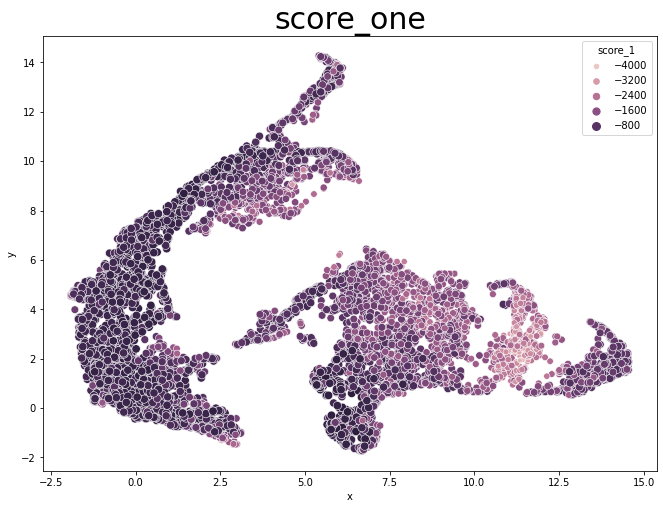

In [43]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data = embed, x='x',y="y", hue="score_1", size ='score_1')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("score_one",fontsize="30")

Text(0.5, 1.0, 'GT score_one')

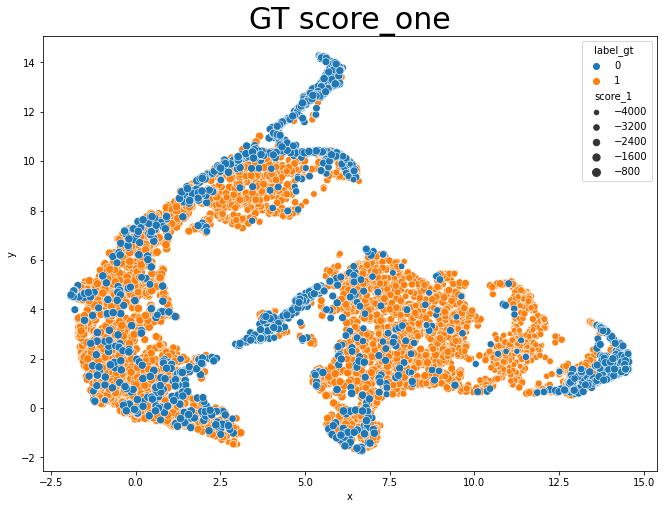

In [44]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data = embed.iloc[::-1], x='x',y="y", hue="label_gt", size ='score_1')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("GT score_one",fontsize="30")

Text(0.5, 1.0, 'score_one')

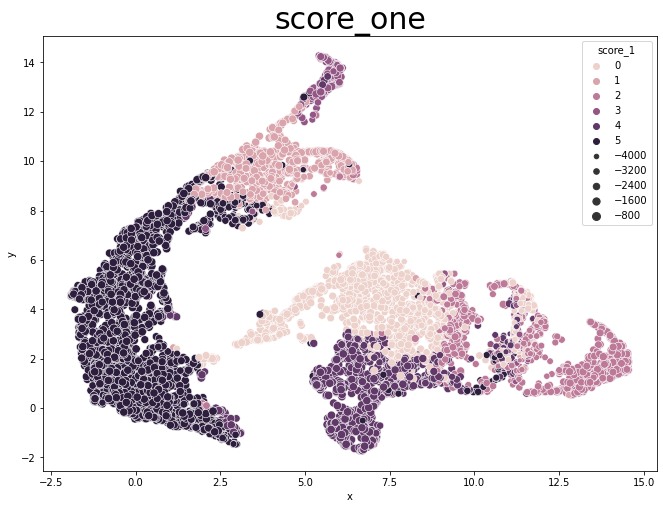

In [55]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data = embed, x='x',y="y", hue=emb[3], size ='score_1')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("score_one",fontsize="30")

Text(0.5, 1.0, 'score_one')

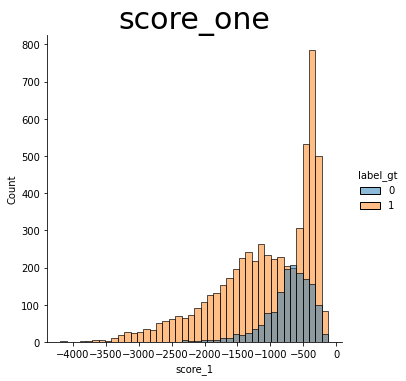

In [46]:
fig = sns.displot(embed, x="score_1", hue="label_gt")
plt.title("score_one",fontsize="30")

In [47]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
n = [0 for i in range(len(emb[1].numpy()))]
N = [1 for i in range(len(emb[2].numpy()))]
n.extend(N)
fpr, tpr, thresholds=roc_curve(n,-embed['score_1'], pos_label=0)
auroc = auc(fpr,tpr)
print(auroc)

0.39370309696633005


In [48]:
def get_scores_multi_cluster(ftrain, ftest, food, ypred, shrunkcov=False):
    xc = [ftrain[ypred == i] for i in np.unique(ypred)]
    if shrunkcov:
        print("Using ledoit-wolf covariance estimator.")
        cov = lambda x: MinCovDet(random_state=0).fit(X).covariance_
        cov = lambda x: ledoit_wolf(x)[0]
    else:
        cov = lambda x: np.cov(x.T, bias=True)
    
    din = [
        np.sum(
            (ftest - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(cov(x)).dot(
                    (ftest - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
    dood = [
        np.sum(
            (food - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(cov(x)).dot(
                    (food - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]

    din = np.min(din, axis=0)
    dood = np.min(dood, axis=0)

    return din, dood

In [49]:
dtest, dood = get_scores_multi_cluster(emb[0].numpy(),emb[1].numpy(),emb[2].numpy(),clad.clusters.numpy())

In [50]:
dd = np.append(dtest, dood)
embed["score_2"] = -dd

Text(0.5, 1.0, 'score_multi')

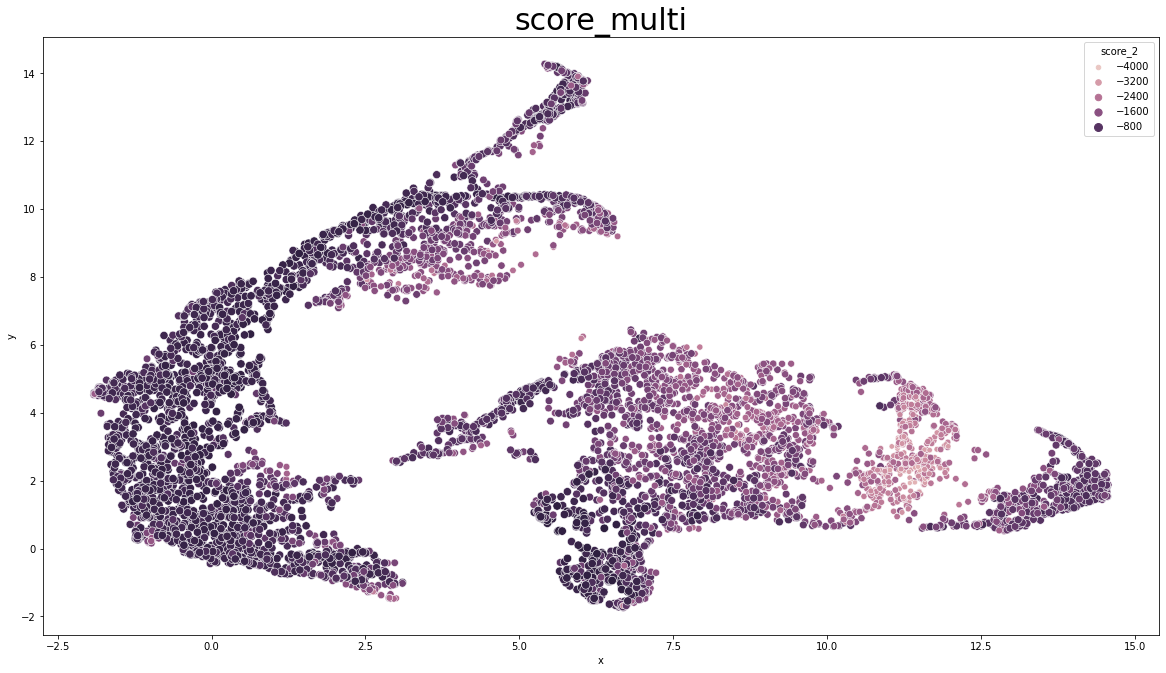

In [51]:
plt.figure(figsize=(20, 11))
fig = sns.scatterplot(data = embed, x='x',y="y", hue="score_2", size ='score_2')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("score_multi",fontsize="30")

Text(0.5, 1.0, 'GT score_multi')

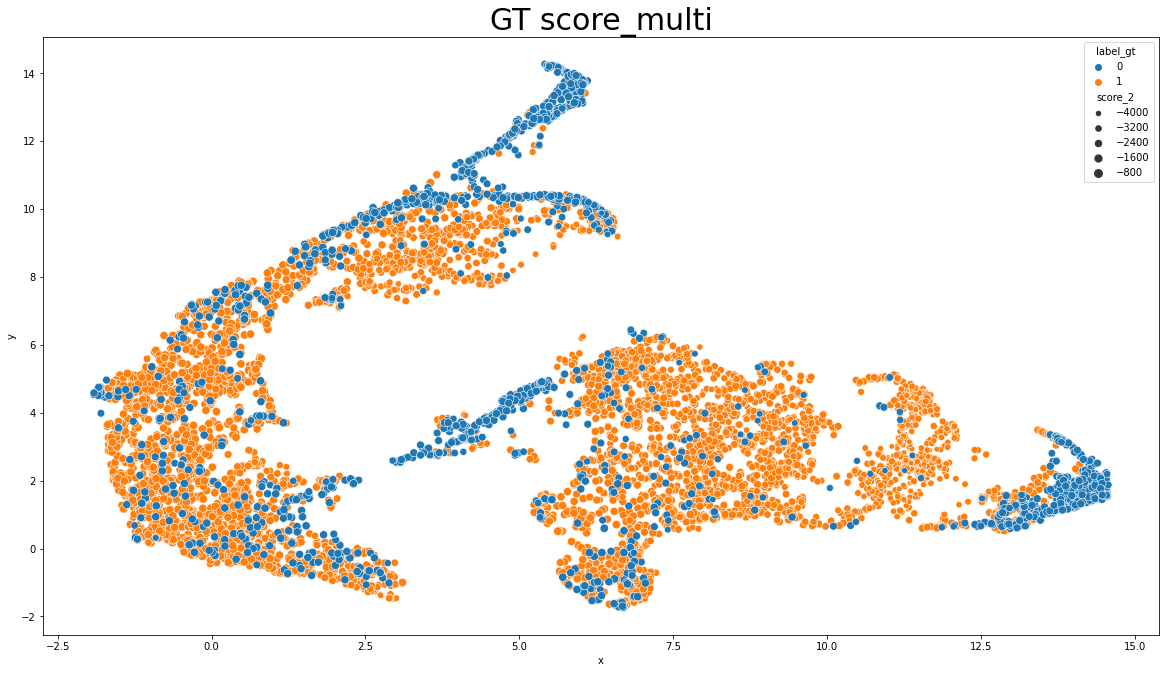

In [52]:
plt.figure(figsize=(20, 11))
fig = sns.scatterplot(data = embed.iloc[::-1], x='x',y="y", hue="label_gt", size ='score_2')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("GT score_multi",fontsize="30")

Text(0.5, 1.0, 'score_multi')

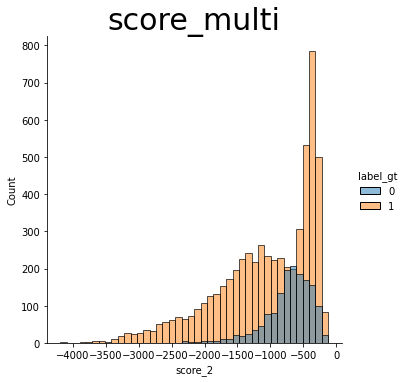

In [53]:
fig = sns.displot(embed, x="score_2",hue="label_gt")
plt.title("score_multi",fontsize="30")

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
n = [0 for i in range(len(emb[1].numpy()))]
N = [1 for i in range(len(emb[2].numpy()))]
n.extend(N)
fpr, tpr, thresholds=roc_curve(n,-embed['score_2'], pos_label=0)
auroc = auc(fpr,tpr)

In [31]:
auroc

0.60629690303367

In [32]:
embed["score_3"] = embed["score_1"] - embed["score_2"] 

In [33]:
fpr, tpr, thresholds=roc_curve(n,embed['score_3'], pos_label=0)
auroc = auc(fpr,tpr)
print(auroc)

0.24389298594730469


In [ ]:
plt.figure(figsize=(20, 11))
fig=sns.scatterplot(data=embed_s, x= 'x',y='y',hue=embed['score_1'],size=embed['score_1'])
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("score in sbert_emb",fontsize="30")

In [ ]:
plt.figure(figsize=(20, 11))
fig=sns.scatterplot(data=embed_s, x= 'x',y='y',hue=embed['label_gt'],size=embed['score_1'])
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("score in sbert_emb",fontsize="30")

In [34]:
import data_util.news20
config.classifier_type ='fc3'
newsdata = data_util.news20.news20_Dataset('../data')
newsdata.preprocess_for_sentiment_understanding()
emd_sbert = newsdata.get_binary_labeled_data()

embedding with s_bert embedding


In [35]:
emd_sbert["test_in"]
emd_sbert["test_out"]

tensor([[-0.5904,  0.1613,  0.1289,  ..., -0.2741,  0.3487, -0.1736],
        [ 0.0887,  0.7081,  0.7516,  ...,  0.2609,  0.2526,  0.2836],
        [ 0.0131, -0.0235,  2.3573,  ...,  0.1739, -0.0238,  0.4290],
        ...,
        [ 0.1513,  0.1958,  1.2294,  ...,  0.2782, -0.4712,  0.4328],
        [ 0.0929,  0.6795,  0.9352,  ..., -0.2230, -1.0887,  0.3154],
        [-0.0753,  0.5625,  0.3876,  ...,  0.2132,  0.5994,  0.0940]])

In [36]:
len(embed['score_2'])

7299

In [37]:
emb_s = np.vstack([emd_sbert["test_in"].numpy(),emd_sbert["test_out"].numpy()])

In [38]:
mapper = umap.UMAP(n_neighbors=15,random_state=42)
embed_s = pd.DataFrame(mapper.fit_transform(emb_s), columns=['x','y'])

Text(0.5, 1.0, 'score in sbert_emb')

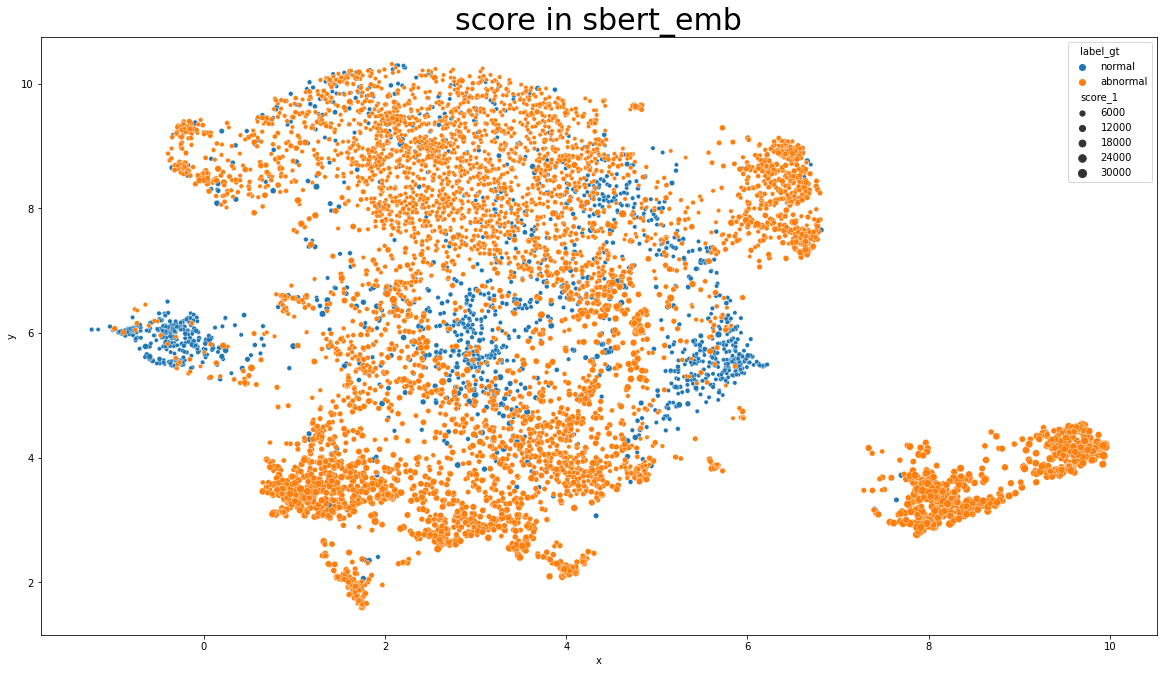

In [39]:
plt.figure(figsize=(20, 11))
fig=sns.scatterplot(data=embed_s, x= 'x',y='y',hue=embed['label_gt'],size=embed['score_1'])
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("score in sbert_emb",fontsize="30")

Text(0.5, 1.0, 'score in sbert_emb')

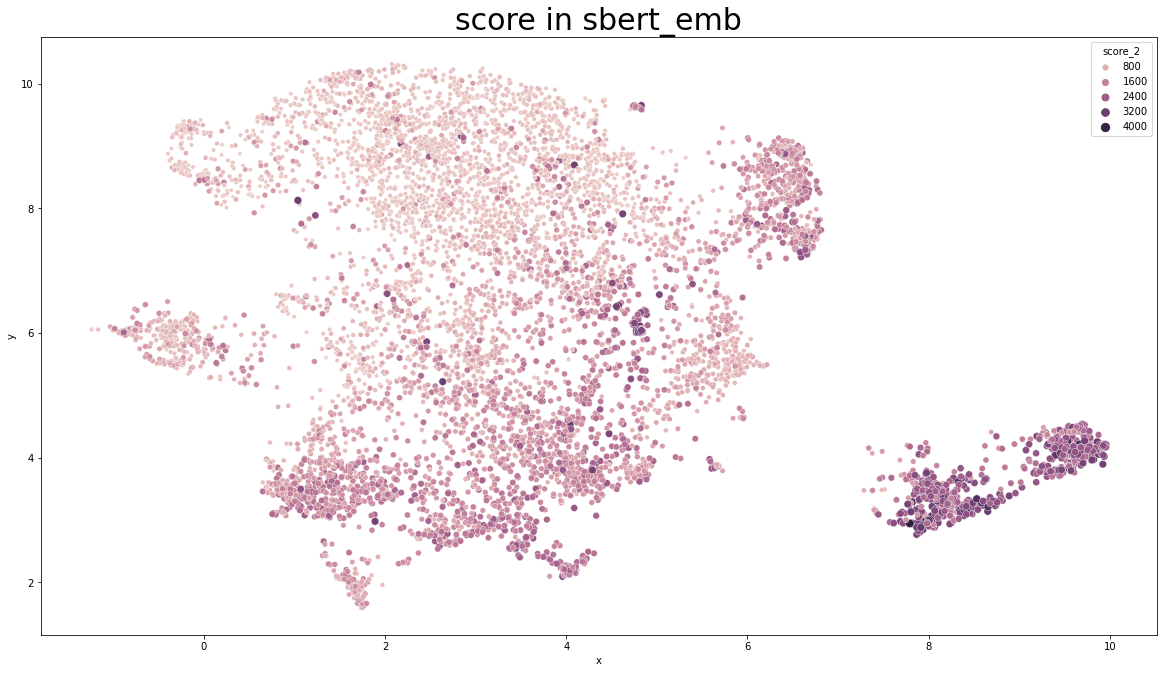

In [40]:
plt.figure(figsize=(20, 11))
fig=sns.scatterplot(data=embed_s, x= 'x',y='y',hue=embed['score_2'],size=embed['score_2'])
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("score in sbert_emb",fontsize="30")